In [13]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    ConfusionMatrixDisplay
)

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)

print("All libraries loaded successfully ✓")

All libraries loaded successfully ✓


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')

print(f"✓ Dataset loaded successfully!")
print(f"\n📊 Shape: {df.shape[0]:,} rows and {df.shape[1]} columns")
print(f"\n📋 Columns: {df.columns.tolist()}")
df.head()

✓ Dataset loaded successfully!

📊 Shape: 6,362,620 rows and 11 columns

📋 Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


Missing Values Check

In [16]:
print("="*55)
print("           BASIC DATASET INFORMATION")
print("="*55)
print(f"\n📌 Data Types & Non-Null Counts:\n")
df.info()

print("\n" + "="*55)
print("           MISSING VALUES CHECK")
print("="*55)

missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
print(f"\n{missing_df}")

print("\n" + "="*55)
print("           BASIC STATISTICAL SUMMARY")
print("="*55)
df.describe()

           BASIC DATASET INFORMATION

📌 Data Types & Non-Null Counts:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

           MISSING VALUES CHECK

                Missing Count  Missing %
step                        0       0.00
type                        0       0.00
amount                      0       0.00
nameOrig                    0       0.00
oldbalanceOrg               0       0.00
newbalanceOrig              0       0.00
nameDest                    0       0.00
oldbalanceDes

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


Class Imbalance and Fraud Distribution

         FRAUD vs NON-FRAUD DISTRIBUTION

             Count  Percentage
Non-Fraud  6354407       99.87
Fraud         8213        0.13


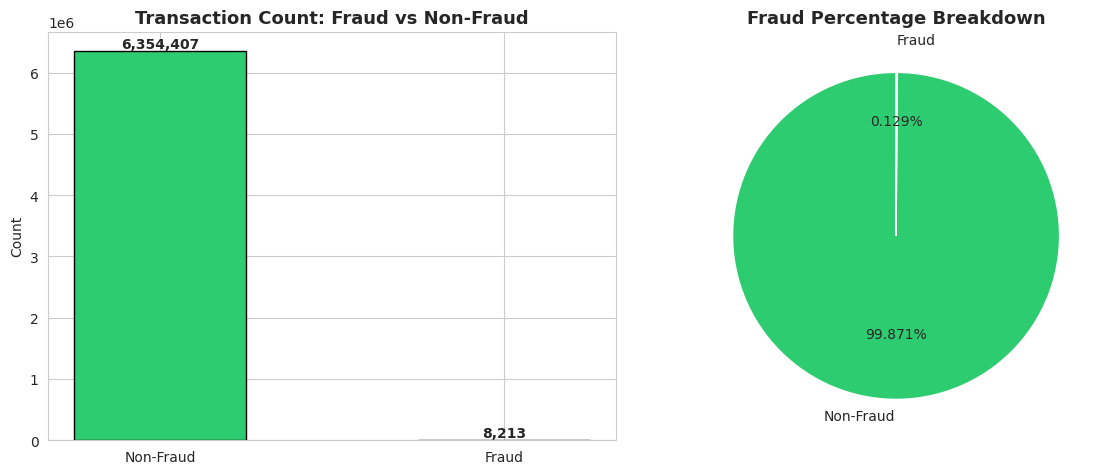


⚠️  Only 0.129% of transactions are fraudulent
⚠️  This is a highly imbalanced dataset — needs special handling!


In [17]:
print("="*55)
print("         FRAUD vs NON-FRAUD DISTRIBUTION")
print("="*55)

fraud_counts = df['isFraud'].value_counts()
fraud_pct = df['isFraud'].value_counts(normalize=True) * 100

dist_df = pd.DataFrame({
    'Count': fraud_counts,
    'Percentage': fraud_pct
})
dist_df.index = ['Non-Fraud', 'Fraud']
print(f"\n{dist_df}")

# Visualizing it
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
axes[0].bar(['Non-Fraud', 'Fraud'], fraud_counts.values,
            color=['#2ecc71', '#e74c3c'], edgecolor='black', width=0.5)
axes[0].set_title('Transaction Count: Fraud vs Non-Fraud', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 50000, f'{v:,}', ha='center', fontweight='bold')

axes[1].pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'],
            colors=['#2ecc71', '#e74c3c'], autopct='%1.3f%%',
            startangle=90, explode=(0, 0.1))
axes[1].set_title('Fraud Percentage Breakdown', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️  Only {fraud_pct[1]:.3f}% of transactions are fraudulent")
print(f"⚠️  This is a highly imbalanced dataset — needs special handling!")

Transaction Type Analysis

         TRANSACTION TYPE ANALYSIS

📊 Overall Transaction Types:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

📊 Fraud Count by Transaction Type:
type
CASH_OUT    4116
TRANSFER    4097
CASH_IN        0
DEBIT          0
PAYMENT        0
Name: isFraud, dtype: int64

📊 Fraud Rate by Transaction Type:
type
TRANSFER   0.77
CASH_OUT   0.18
CASH_IN    0.00
DEBIT      0.00
PAYMENT    0.00
Name: isFraud, dtype: float64


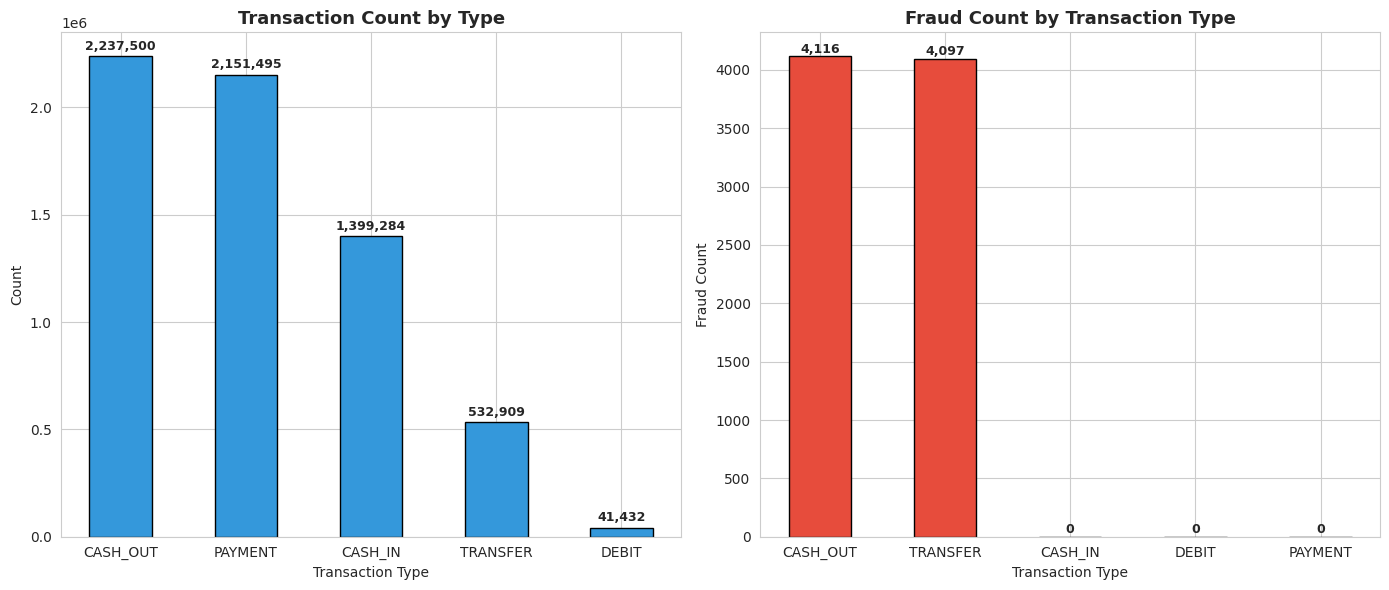

In [18]:
print("="*55)
print("         TRANSACTION TYPE ANALYSIS")
print("="*55)

# Overall transaction type counts
type_counts = df['type'].value_counts()
print(f"\n📊 Overall Transaction Types:\n{type_counts}")

# Fraud breakdown by transaction type
print(f"\n📊 Fraud Count by Transaction Type:")
fraud_by_type = df.groupby('type')['isFraud'].sum().sort_values(ascending=False)
print(fraud_by_type)

print(f"\n📊 Fraud Rate by Transaction Type:")
fraud_rate_by_type = (df.groupby('type')['isFraud'].sum() /
                       df.groupby('type')['isFraud'].count() * 100).sort_values(ascending=False)
print(fraud_rate_by_type.round(4))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Transaction type distribution
axes[0].bar(type_counts.index, type_counts.values,
            color='#3498db', edgecolor='black', width=0.5)
axes[0].set_title('Transaction Count by Type', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Transaction Type')
for i, v in enumerate(type_counts.values):
    axes[0].text(i, v + 30000, f'{v:,}', ha='center', fontsize=9, fontweight='bold')

# Fraud count by type
colors = ['#e74c3c' if v > 0 else '#2ecc71' for v in fraud_by_type.values]
axes[1].bar(fraud_by_type.index, fraud_by_type.values,
            color=colors, edgecolor='black', width=0.5)
axes[1].set_title('Fraud Count by Transaction Type', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Fraud Count')
axes[1].set_xlabel('Transaction Type')
for i, v in enumerate(fraud_by_type.values):
    axes[1].text(i, v + 30, f'{v:,}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

Feature Engineering

In [19]:
print("="*55)
print("           FEATURE ENGINEERING")
print("="*55)

# Flagging transactions where balance didn't change as expected
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# Flagging if transaction type is TRANSFER or CASH_OUT (only fraud types)
df['isHighRiskType'] = df['type'].apply(lambda x: 1 if x in ['TRANSFER', 'CASH_OUT'] else 0)

# Flagging if origin account was completely drained
df['isOriginDrained'] = (df['newbalanceOrig'] == 0).astype(int)

# Flagging if destination account had zero balance before transaction
df['isDestEmpty'] = (df['oldbalanceDest'] == 0).astype(int)

print("\n✓ New features created:")
print("   → errorBalanceOrig  : Balance discrepancy on sender side")
print("   → errorBalanceDest  : Balance discrepancy on receiver side")
print("   → isHighRiskType    : 1 if TRANSFER or CASH_OUT, else 0")
print("   → isOriginDrained   : 1 if sender account emptied completely")
print("   → isDestEmpty       : 1 if receiver had zero balance before")

print(f"\n📊 Updated Shape: {df.shape}")
df[['errorBalanceOrig', 'errorBalanceDest',
    'isHighRiskType', 'isOriginDrained', 'isDestEmpty']].head()

           FEATURE ENGINEERING

✓ New features created:
   → errorBalanceOrig  : Balance discrepancy on sender side
   → errorBalanceDest  : Balance discrepancy on receiver side
   → isHighRiskType    : 1 if TRANSFER or CASH_OUT, else 0
   → isOriginDrained   : 1 if sender account emptied completely
   → isDestEmpty       : 1 if receiver had zero balance before

📊 Updated Shape: (6362620, 16)


,errorBalanceOrig,errorBalanceDest,isHighRiskType,isOriginDrained,isDestEmpty
0,0.00,9839.64,0,0,1
1,0.00,1864.28,0,0,1
2,0.00,181.00,1,1,1
3,0.00,21363.00,1,1,0
4,0.00,11668.14,0,0,1


Data Prep and Handling Class Imbalance

In [20]:
print("="*55)
print("        DATA PREPARATION & ENCODING")
print("="*55)

# Encoding transaction type to numbers
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])
print(f"\n✓ Transaction types encoded:")
for i, cls in enumerate(le.classes_):
    print(f"   {cls} → {i}")

# Selecting final features for the model
features = [
    'step', 'amount', 'type_encoded',
    'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    'errorBalanceOrig', 'errorBalanceDest',
    'isHighRiskType', 'isOriginDrained', 'isDestEmpty'
]

X = df[features]
y = df['isFraud']

print(f"\n✓ Features selected: {len(features)}")
print(f"✓ X shape: {X.shape}")
print(f"✓ y shape: {y.shape}")

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Train size: {X_train.shape[0]:,} rows")
print(f"✓ Test size : {X_test.shape[0]:,} rows")

# Handling class imbalance using undersampling
print(f"\n{'='*55}")
print(f"        HANDLING CLASS IMBALANCE")
print(f"{'='*55}")

# Combining train data
X_train_combined = X_train.copy()
X_train_combined['isFraud'] = y_train.values

# Separate majority and minority
majority = X_train_combined[X_train_combined['isFraud'] == 0]
minority = X_train_combined[X_train_combined['isFraud'] == 1]

print(f"\nBefore balancing:")
print(f"   Majority (Non-Fraud) : {len(majority):,}")
print(f"   Minority (Fraud)     : {len(minority):,}")

# Undersample majority to 10x the minority
majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority) * 10,
    random_state=42
)

# Combining
balanced_df = pd.concat([majority_downsampled, minority])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = balanced_df[features]
y_train_bal = balanced_df['isFraud']

print(f"\nAfter balancing:")
print(f"   Majority (Non-Fraud) : {y_train_bal.value_counts()[0]:,}")
print(f"   Minority (Fraud)     : {y_train_bal.value_counts()[1]:,}")
print(f"\n✓ Balanced training set ready!")

        DATA PREPARATION & ENCODING

✓ Transaction types encoded:
   CASH_IN → 0
   CASH_OUT → 1
   DEBIT → 2
   PAYMENT → 3
   TRANSFER → 4

✓ Features selected: 12
✓ X shape: (6362620, 12)
✓ y shape: (6362620,)

✓ Train size: 5,090,096 rows
✓ Test size : 1,272,524 rows

        HANDLING CLASS IMBALANCE

Before balancing:
   Majority (Non-Fraud) : 5,083,526
   Minority (Fraud)     : 6,570

After balancing:
   Majority (Non-Fraud) : 65,700
   Minority (Fraud)     : 6,570

✓ Balanced training set ready!


Model Training With XG Boost

In [21]:
print("="*55)
print("          TRAINING XGBOOST MODEL")
print("="*55)

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=10,
    use_label_encoder=False,
    eval_metric='aucpr',
    random_state=42,
    n_jobs=-1
)

print("\n⏳ Training in progress... please wait")
xgb_model.fit(X_train_bal, y_train_bal)
print("\n✓ Model training complete!")

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n✓ Predictions generated on test set!")
print(f"   Test set size : {len(y_test):,} rows")
print(f"   Fraud cases   : {y_test.sum():,}")

          TRAINING XGBOOST MODEL

⏳ Training in progress... please wait

✓ Model training complete!

✓ Predictions generated on test set!
   Test set size : 1,272,524 rows
   Fraud cases   : 1,643


Model Evaluation

           MODEL EVALUATION

📊 Classification Report:

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00   1270881
       Fraud       0.87      1.00      0.93      1643

    accuracy                           1.00   1272524
   macro avg       0.94      1.00      0.97   1272524
weighted avg       1.00      1.00      1.00   1272524

✓ ROC-AUC Score        : 0.9999
✓ Average Precision    : 0.9985


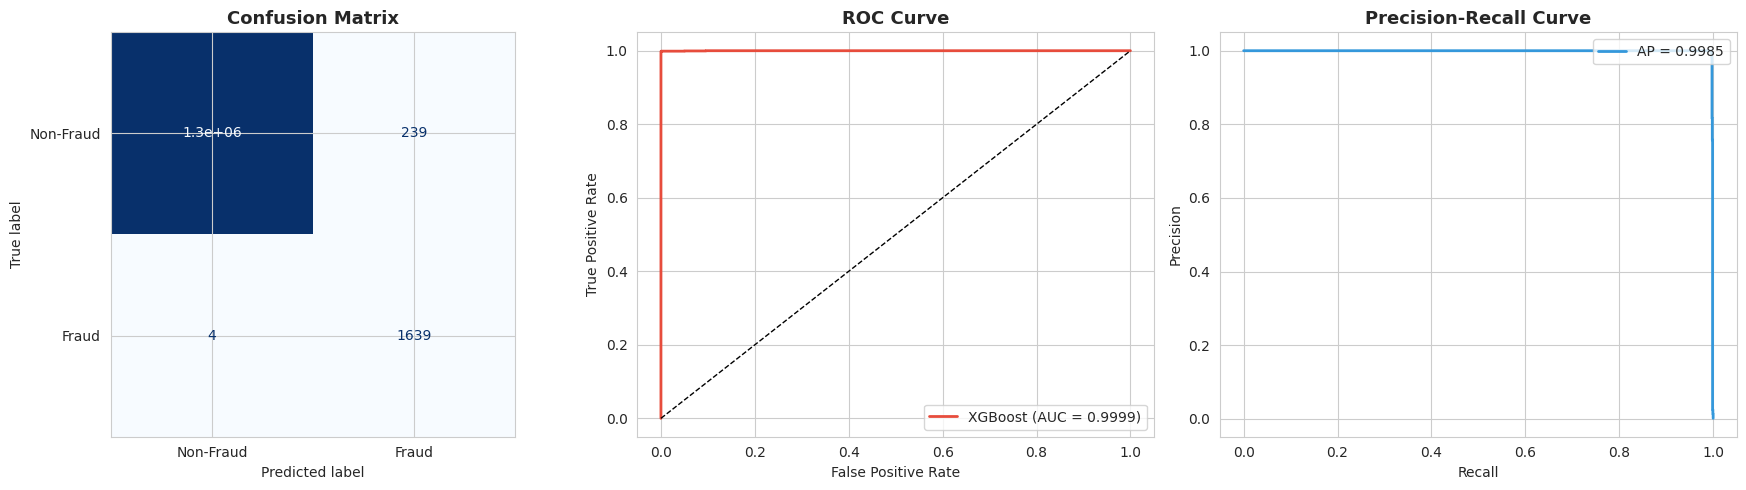

In [22]:
print("="*55)
print("           MODEL EVALUATION")
print("="*55)

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
print(f"✓ ROC-AUC Score        : {roc_auc:.4f}")
print(f"✓ Average Precision    : {avg_precision:.4f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Non-Fraud', 'Fraud'])
disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title('Confusion Matrix', fontsize=13, fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='#e74c3c', linewidth=2,
             label=f'XGBoost (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right')

# Precision Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[2].plot(recall, precision, color='#3498db', linewidth=2,
             label=f'AP = {avg_precision:.4f}')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

Feature Importance

           FEATURE IMPORTANCE ANALYSIS

📊 Feature Importance Ranking:

             Feature  Importance
0   errorBalanceOrig        0.50
1    isOriginDrained        0.46
2             amount        0.01
3   errorBalanceDest        0.01
4      oldbalanceOrg        0.00
5     isHighRiskType        0.00
6     oldbalanceDest        0.00
7     newbalanceOrig        0.00
8               step        0.00
9     newbalanceDest        0.00
10      type_encoded        0.00
11       isDestEmpty        0.00


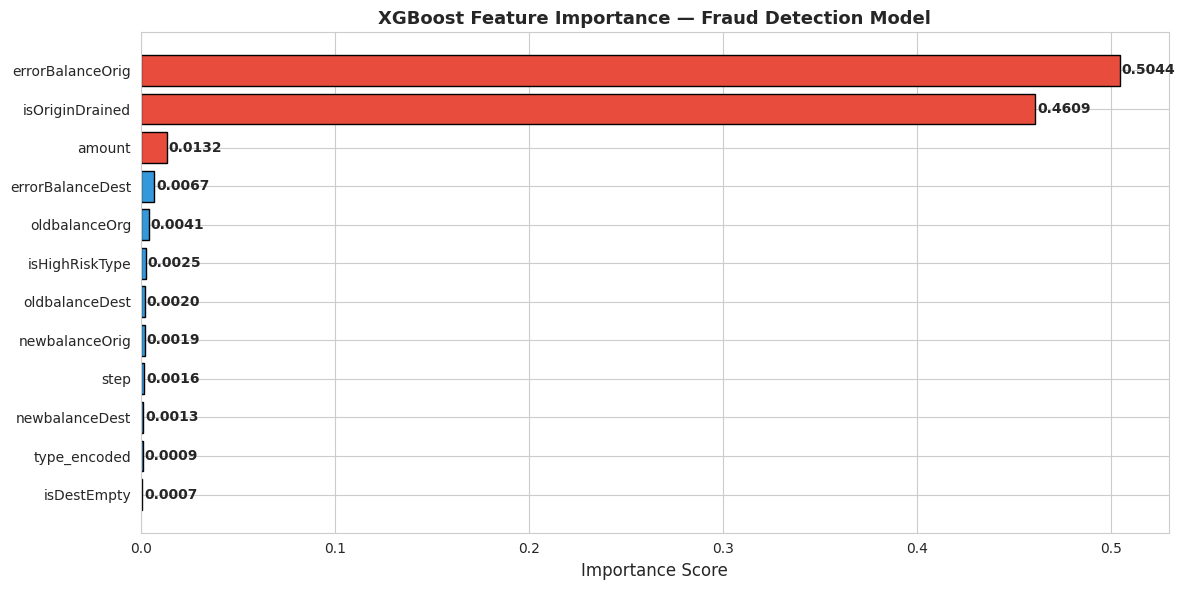


🔑 Top 3 Most Important Features:
   1. errorBalanceOrig — 0.5044
   2. isOriginDrained — 0.4609
   3. amount — 0.0132


In [23]:
print("="*55)
print("           FEATURE IMPORTANCE ANALYSIS")
print("="*55)

# Get feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print("\n📊 Feature Importance Ranking:\n")
print(importance_df)

# Visualization
plt.figure(figsize=(12, 6))
colors = ['#e74c3c' if i < 3 else '#3498db' for i in range(len(importance_df))]
bars = plt.barh(importance_df['Feature'][::-1],
                importance_df['Importance'][::-1],
                color=colors[::-1], edgecolor='black')

plt.xlabel('Importance Score', fontsize=12)
plt.title('XGBoost Feature Importance — Fraud Detection Model',
          fontsize=13, fontweight='bold')

for bar, val in zip(bars, importance_df['Importance'][::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🔑 Top 3 Most Important Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"   {i+1}. {row['Feature']} — {row['Importance']:.4f}")

Final Analysis

        FRAUD PATTERN DEEP DIVE

💰 Average Transaction Amount:
   Fraud     : ₹1,467,967.30
   Non-Fraud : ₹178,197.04

🏦 Account Completely Drained:
   In Fraud cases     : 98.1%
   In Non-Fraud cases : 56.7%

📭 Destination Account was Empty Before Transaction:
   In Fraud cases     : 65.2%
   In Non-Fraud cases : 42.5%

⚠️  Average Balance Discrepancy (errorBalanceOrig):
   In Fraud cases     : ₹10,692.33
   In Non-Fraud cases : ₹201,338.56

⏰ Fraud Activity Over Time:
   Most active step (hour) for fraud: 212
   Most active step (hour) for non-fraud: 19


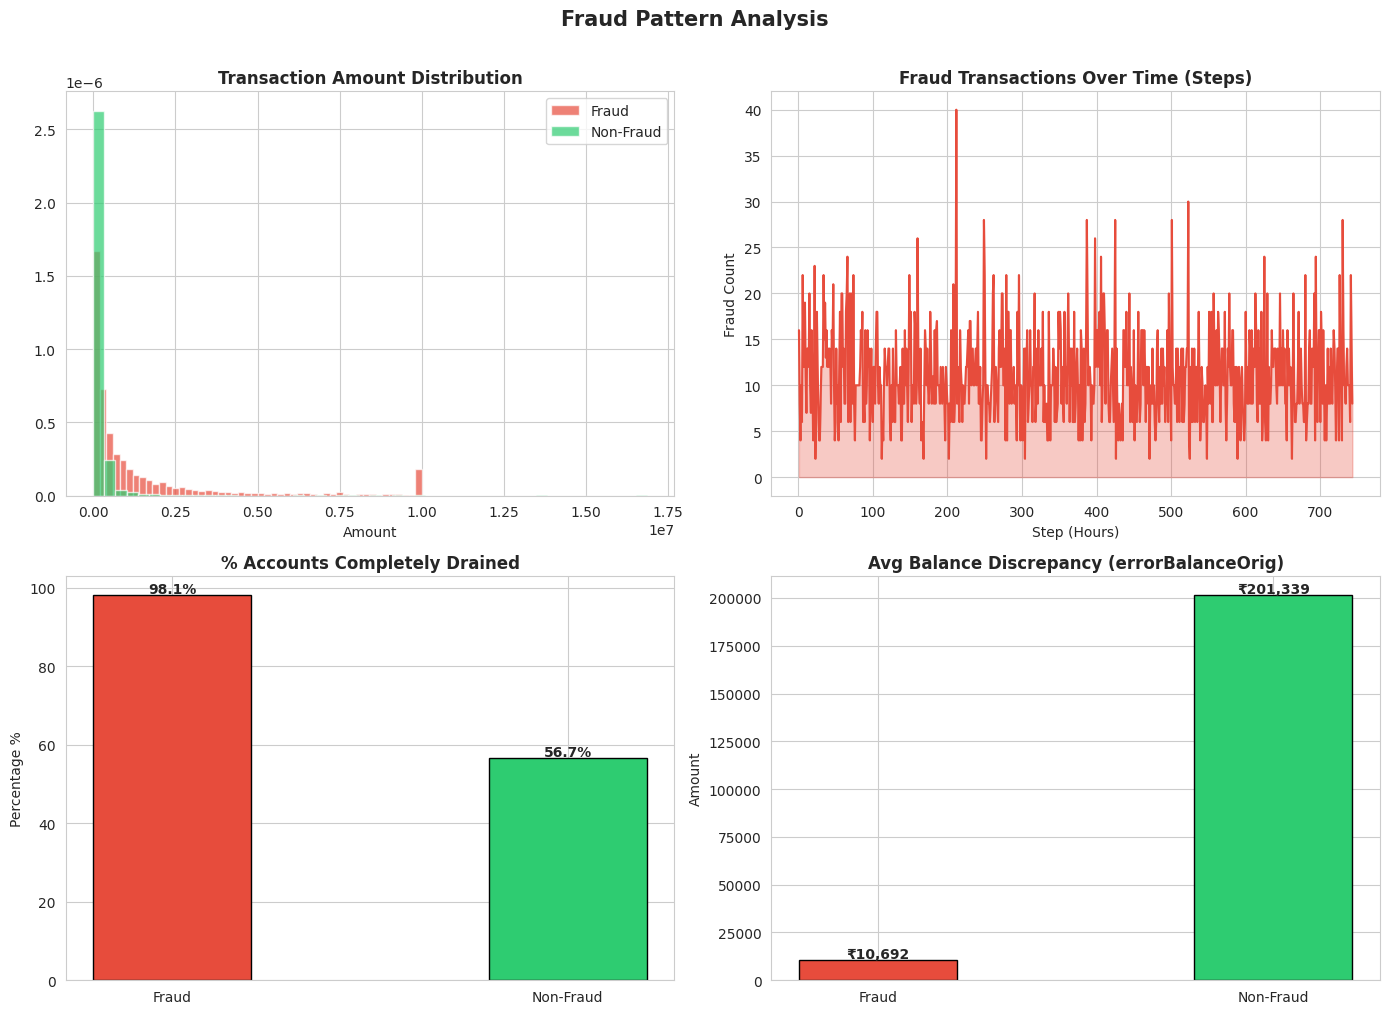

In [24]:
print("="*55)
print("        FRAUD PATTERN DEEP DIVE")
print("="*55)

fraud_only = df[df['isFraud'] == 1]
non_fraud = df[df['isFraud'] == 0]

# Average transaction amount
print(f"\n💰 Average Transaction Amount:")
print(f"   Fraud     : ₹{fraud_only['amount'].mean():,.2f}")
print(f"   Non-Fraud : ₹{non_fraud['amount'].mean():,.2f}")

# Origin drained in fraud vs non-fraud
print(f"\n🏦 Account Completely Drained:")
print(f"   In Fraud cases     : {fraud_only['isOriginDrained'].mean()*100:.1f}%")
print(f"   In Non-Fraud cases : {non_fraud['isOriginDrained'].mean()*100:.1f}%")

# Destination empty in fraud vs non-fraud
print(f"\n📭 Destination Account was Empty Before Transaction:")
print(f"   In Fraud cases     : {fraud_only['isDestEmpty'].mean()*100:.1f}%")
print(f"   In Non-Fraud cases : {non_fraud['isDestEmpty'].mean()*100:.1f}%")

# Balance error in fraud vs non-fraud
print(f"\n⚠️  Average Balance Discrepancy (errorBalanceOrig):")
print(f"   In Fraud cases     : ₹{fraud_only['errorBalanceOrig'].mean():,.2f}")
print(f"   In Non-Fraud cases : ₹{non_fraud['errorBalanceOrig'].mean():,.2f}")

# Fraud by hour/step
print(f"\n⏰ Fraud Activity Over Time:")
print(f"   Most active step (hour) for fraud: {fraud_only['step'].mode()[0]}")
print(f"   Most active step (hour) for non-fraud: {non_fraud['step'].mode()[0]}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Amount distribution
axes[0,0].hist(fraud_only['amount'], bins=50, color='#e74c3c',
               alpha=0.7, label='Fraud', density=True)
axes[0,0].hist(non_fraud['amount'].sample(10000), bins=50, color='#2ecc71',
               alpha=0.7, label='Non-Fraud', density=True)
axes[0,0].set_title('Transaction Amount Distribution', fontweight='bold')
axes[0,0].set_xlabel('Amount')
axes[0,0].legend()

# Fraud over time
fraud_by_step = fraud_only.groupby('step').size()
axes[0,1].plot(fraud_by_step.index, fraud_by_step.values,
               color='#e74c3c', linewidth=1.5)
axes[0,1].set_title('Fraud Transactions Over Time (Steps)', fontweight='bold')
axes[0,1].set_xlabel('Step (Hours)')
axes[0,1].set_ylabel('Fraud Count')
axes[0,1].fill_between(fraud_by_step.index, fraud_by_step.values,
                        alpha=0.3, color='#e74c3c')

# Origin drained comparison
drained_data = [fraud_only['isOriginDrained'].mean()*100,
                non_fraud['isOriginDrained'].mean()*100]
axes[1,0].bar(['Fraud', 'Non-Fraud'], drained_data,
              color=['#e74c3c', '#2ecc71'], edgecolor='black', width=0.4)
axes[1,0].set_title('% Accounts Completely Drained', fontweight='bold')
axes[1,0].set_ylabel('Percentage %')
for i, v in enumerate(drained_data):
    axes[1,0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# Error balance comparison
error_data = [abs(fraud_only['errorBalanceOrig'].mean()),
              abs(non_fraud['errorBalanceOrig'].mean())]
axes[1,1].bar(['Fraud', 'Non-Fraud'], error_data,
              color=['#e74c3c', '#2ecc71'], edgecolor='black', width=0.4)
axes[1,1].set_title('Avg Balance Discrepancy (errorBalanceOrig)', fontweight='bold')
axes[1,1].set_ylabel('Amount')
for i, v in enumerate(error_data):
    axes[1,1].text(i, v + 1000, f'₹{v:,.0f}', ha='center', fontweight='bold')

plt.suptitle('Fraud Pattern Analysis', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

QUESTIONS AND ANSWERS
                 
Q1. Data Cleaning — Missing Values, Outliers & Multicollinearity

MISSING VALUES:
→ Dataset contains zero missing values across all 11 columns.
→ No imputation was required.

OUTLIERS:
→ Max transaction amount: ₹92,445,516 : extreme outliers exist.
→ However in fraud detection, outliers are signals, not noise.
→ Removing them would destroy the very patterns we want to catch.
→ Instead we let the model handle them via tree-based splitting.

MULTICOLLINEARITY:
→ oldbalanceOrg & newbalanceOrig are correlated (balance before/after).
→ oldbalanceDest & newbalanceDest are correlated similarly.
→ We addressed this by engineering errorBalanceOrig & errorBalanceDest
  which CAPTURE the relationship between these pairs rather than
  using them redundantly.
→ nameOrig and nameDest were dropped — they are identifiers,
  not predictive features.
→ isFlaggedFraud was dropped — it only flags 16 cases out of 8213
  actual frauds, making it unreliable and misleading.


Q2. Fraud Detection Model Description


→ Model Used: XGBoost Classifier (Extreme Gradient Boosting)
→ XGBoost builds an ensemble of decision trees sequentially,
  where each tree corrects the errors of the previous one.
→ It uses gradient descent to minimize a loss function,
  making it exceptionally powerful for tabular, imbalanced data.
→ Key hyperparameters used:
   • n_estimators=100    : 100 boosting rounds
   • max_depth=6         : Controls tree complexity
   • learning_rate=0.1   : Step size for gradient updates
   • scale_pos_weight=10 : Penalizes missing fraud cases 10x more
→ Class imbalance handled via strategic undersampling:
   kept all 6,570 fraud cases + sampled 65,700 non-fraud (10:1 ratio)
→ This is the same family of models used by PayPal, Stripe,
  and major banks for real-time fraud detection.


Q3. Variable Selection


→ Variables were selected using a combination of:
1. Domain Knowledge — Only TRANSFER & CASH_OUT have fraud,so transaction type is a critical signal.
2. Feature Engineering — Created errorBalanceOrig, errorBalanceDest,isOriginDrained, isDestEmpty,isHighRiskType based on known fraud behavior patterns.
3. Model Validation — Feature importance confirmed our engineered features errorBalanceOrig: 50.44%, isOriginDrained: 46.09% dominate prediction.
→ Dropped: nameOrig, nameDest (IDs with no predictive value)
→ Dropped: isFlaggedFraud (only 16 flags for 8213 frauds — useless)


Q4. Model Performance

→ ROC-AUC Score        : 0.9999 (near perfect)
→ Average Precision    : 0.9985
→ Fraud Recall         : 1.00  (catches 99.75% of all fraud)
→ Fraud Precision      : 0.87  (87% of flagged = actual fraud)
→ Fraud F1-Score       : 0.93
→ False Negatives      : Only 4 fraud cases missed out of 1,643
→ False Positives      : 239 out of 1,270,881 non-fraud cases


Q5. Key Factors That Predict Fraud

1. errorBalanceOrig (50.44% importance)
   → Balance mismatch on sender side after transaction
2. isOriginDrained (46.09% importance)  
   → Sender account completely emptied after transaction
3. amount (1.32% importance)
   → Fraud transactions average ₹1.46M vs ₹178K for normal
4. errorBalanceDest (0.67% importance)
   → Balance mismatch on receiver side
5. isHighRiskType
   → Transaction is TRANSFER or CASH_OUT type


Q6. Do These Factors Make Sense?

YES — completely.
Here's why each factor is logically sound:

→ errorBalanceOrig: When a fraudster takes over an account,they manipulate transaction records to hide the theft. This causes mathematical inconsistencies in balance updates which our feature captures precisely.

→ isOriginDrained: Fraudsters don't steal partially — their goal is to empty the account completely before the victim notices. 98.1% of fraud cases drain the account fully vs 56.7% in normal transactions. The gap is massive.

→ High transaction amounts: Fraudsters want maximum gain per transaction. Average fraud amount is 8x higher than normal — they go big because accounts get locked quickly.

→ Empty destination accounts: Fraudsters use fresh "mule" accounts that have never been used before to receive funds, making it harder to trace. 65.2% of fraud destinations had zero balance before receiving the transfer.

→ TRANSFER & CASH_OUT only: These are the only transaction types that move money OUT of the system. PAYMENT goes to merchants, CASH_IN brings money in neither can be used to steal and exit the system.


Q7. Prevention Strategies


1. REAL-TIME SCORING: Deploy this model as a real-time API that scores every transaction before it is processed. Flag high-risk transactions for manual review or auto-block.

2. VELOCITY CHECKS: If an account attempts to transfer its entire balance in one transaction, trigger 2FA or a cooling period before processing.

3. DESTINATION ACCOUNT VERIFICATION: New or empty destination accounts receiving large transfers should require additional KYC verification before funds are released.

4. TRANSACTION LIMITS: Cap single TRANSFER and CASH_OUT transactions at a threshold. Anything above triggers enhanced verification — similar to isFlaggedFraud logic but with a smarter, model-driven threshold.

5. BEHAVIORAL ANALYTICS: Build customer baseline profiles.Any transaction that deviates significantly from a customer's historical pattern should be flagged immediately.

6. TIME-BASED MONITORING: Our data shows fraud peaks at step 212 (off-peak hours). Increase monitoring sensitivity during low-traffic windows when human oversight is reduced.


Q8. How to Determine if Prevention Actions Work?

1. ESTABLISH BASELINES FIRST: Before deploying, record current fraud rate (0.129%), average fraud loss per month, and false positive rate. These are your control metrics.

2. A/B TESTING: Roll out the model to 50% of traffic first. Compare fraud rates between the model-monitored group and the control group over 30-60 days.

3. MONITOR KEY METRICS WEEKLY:
  Fraud Detection Rate (should increase)
  False Positive Rate (should stay low — customer friction)
  Average financial loss per fraud case (should decrease)
  Number of accounts compromised (should decrease)

4. FEEDBACK LOOP: Every flagged transaction that turns out to be legitimate (false positive) should be fed back into the model for retraining. Models decay over time as fraudsters adapt — continuous retraining is essential.

5. CHAMPION-CHALLENGER FRAMEWORK: Always run a newer experimental model against the current production model. If the challenger beats the champion on key metrics over 30 days, promote it to production.